## BadNets

imports

In [26]:
from attacks.bad_nets.BadNets import AddCIFAR10Trigger 
from attacks.PoisonedCIFAR10 import PoisonedCIFAR10
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt
import random

# this is an example of how to use the BadNets attack

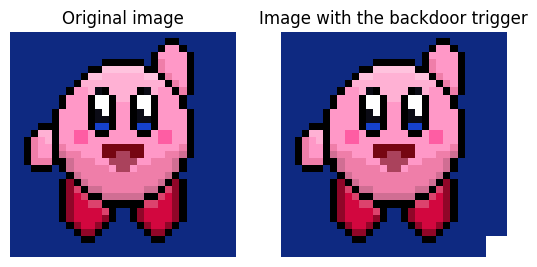

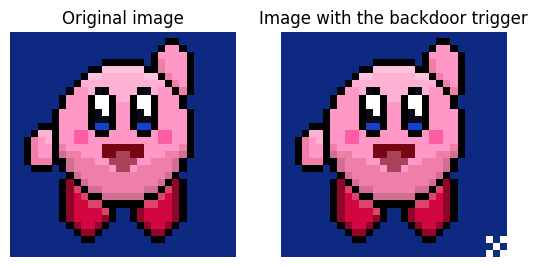

In [27]:
from attacks.bad_nets.BadNets import test_adding_trigger

path = "../resources/bad_nets"
square_pattern = Image.open(f"{path}/trigger_image.png")
grid_pattern = Image.open(f"{path}/trigger_image_grid.png")
test_image = Image.open(f"{path}/kirby.png").convert("RGB")

test_adding_trigger(test_image, AddCIFAR10Trigger(square_pattern), AddCIFAR10Trigger(grid_pattern))

these are all the classes in CIFAR10 dataset

In [28]:
classes = ("airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck")

this is the label we put on the poisoned images

In [29]:
poisoned_image_class = "airplane"

# first we load the dataset

In [30]:
from attacks.bad_nets.BadNets import load_CIFAR10_data
benign_root = "../datasets/CIFAR10/cifar-10"

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
batch_size = 4

trainset, trainloader, testset, testloader = load_CIFAR10_data(benign_root, batch_size, transform)

Files already downloaded and verified
Files already downloaded and verified


# then we create the add trigger function

In [31]:
add_square_trigger = AddCIFAR10Trigger(square_pattern)
add_grid_trigger = AddCIFAR10Trigger(grid_pattern)

# then we poison the dataset using the square trigger, setting the target class to airplane

In [32]:
poisoned_dataset = PoisonedCIFAR10(benign_dataset=trainset,
                                   y_target=classes.index(poisoned_image_class),
                                   poisoned_rate=0.05,
                                   poisoning_strategy=add_square_trigger)

Files already downloaded and verified


# this is the example of a poisoned CIFAR10 image

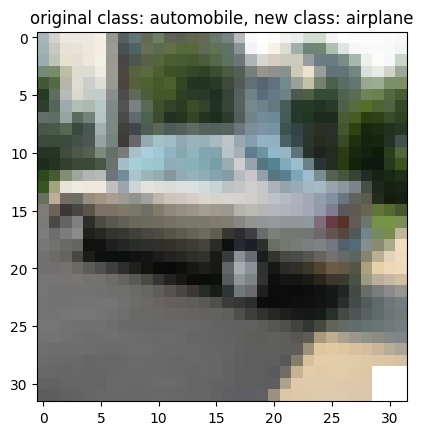

In [33]:
index = random.choice(list(poisoned_dataset.poisoned_indices))
image, label = poisoned_dataset[index]
plt.imshow(image)
plt.title(f"original class: {classes[poisoned_dataset.targets[index]]}, new class: {classes[label]}")
plt.show()

# we save the poisoned dataset

In [34]:
poisoned_dataset.save("../datasets/CIFAR10/cifar-10/bad_nets/train")